Here i can write what happends in the cell below

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


Read the data

In [ ]:
df = pd.read_csv('data\QAQC\swe_qaqc_train.csv')

# Step 2: Extract the text data (adjust column name to your CSV structure)
sentences = df['text'].tolist()


<>:66: SyntaxWarning: invalid escape sequence '\Q'
<>:66: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\gonor\AppData\Local\Temp\ipykernel_32216\593661750.py:66: SyntaxWarning: invalid escape sequence '\Q'
  df = pd.read_csv('data\QAQC\swe_qaqc_train.csv')
c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 171/171 [00:15<00:00, 10.95it/s]
c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


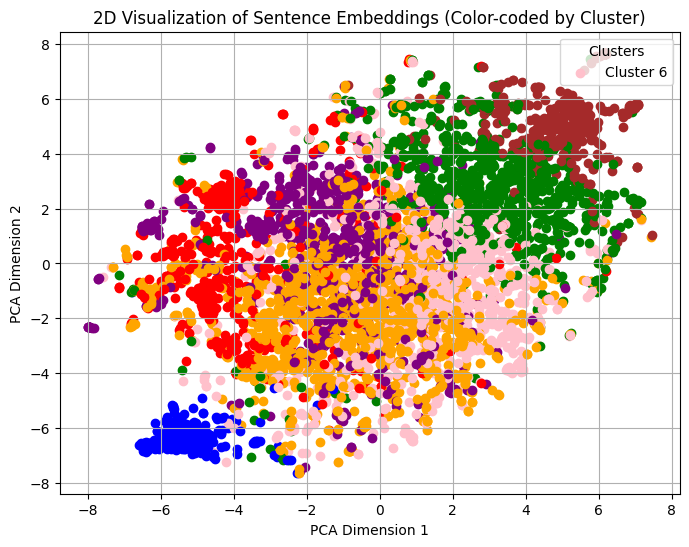

In [7]:


# ##.\envISBIT\Scripts\activate to activate my virtual environment
# ## "deactivate" to deactivate it
# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# # Load the CSV file into a DataFrame
# df = pd.read_csv('ML/swe_qaqc_train.csv')

# # Print the first 5 rows of the DataFrame to verify the contents
# print(df.head())
# # Load a pre-trained SBERT model
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # List of sentences to encode
# sentences = df['text'].tolist()

# # Get sentence embeddings
# embeddings = model.encode(sentences, show_progress_bar=True)
# # pca = PCA(n_components=2)
# # embedding_2d = pca.fit_transform(embeddings)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# embedding_2d = tsne.fit_transform(embeddings)


# # Print the embeddings
# #for sentence, embedding in zip(sentences, embeddings):
# #    print(f"Sentence: {sentence}")
# #    print(f"Embedding: {embedding[:1]}...")  # Print the first 5 dimensions of the embedding for brevity
# #    print()
# #print(f"Embedding dimensions: {len(embeddings[0])}")
# for i, (sentence, embedding) in enumerate(zip(sentences, embeddings)):
#     if i >= 10:
#         break  # Stop after printing 10 sentences
#     print(f"Sentence {i + 1}: {sentence}")
#     print(f"Embedding {i + 1} (first 5 dimensions): {embedding[:5]}\n")
# plt.figure(figsize=(8, 6))
# for i, sentence in enumerate(sentences):
#     plt.scatter(embedding_2d[i, 0], embedding_2d[i, 1])
#     #plt.text(embedding_2d[i, 0] + 0.01, embedding_2d[i, 1] + 0.01, sentence[:20], fontsize=9)  # Display the first 20 chars of the sentence

# plt.title("2D Visualization of Sentence Embeddings")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.grid(True)
# plt.show()




# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# Step 1: Load the CSV file into a DataFrame (adjust path and column as needed)

# Step 3: Load a pre-trained SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Step 4: Generate embeddings for the extracted sentences
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 5: Use KMeans to cluster the embeddings into 3 clusters
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels (0, 1, 2) for each embedding
cluster_labels = kmeans.labels_

# Step 6: Define a color map to assign colors to clusters
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan'
}
colors = [color_map[label] for label in cluster_labels]

# Step 7: Apply PCA to reduce the embeddings to 2D for visualization
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embeddings)

# Step 8: Plot the 2D embeddings with color-coding by cluster
plt.figure(figsize=(8, 6))
for i, (embedding, cluster_label) in enumerate(zip(embedding_2d, cluster_labels)):
    plt.scatter(embedding[0], embedding[1], color=colors[i], label=f'Cluster {cluster_label}' if i == 0 else "")
    #plt.text(embedding[0] + 0.01, embedding[1] + 0.01, f"Point {i+1}", fontsize=9)

# Add legend and labels
plt.legend(loc='upper right', title="Clusters")
plt.title("2D Visualization of Sentence Embeddings (Color-coded by Cluster)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()
